29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch: 1, Test set ELBO: -531.5507
Epoch: 2, Test set ELBO: -526.0771
Epoch: 3, Test set ELBO: -524.0355
Epoch: 4, Test set ELBO: -523.4494
Epoch: 5, Test set ELBO: -522.9907
Epoch: 6, Test set ELBO: -522.7770
Epoch: 7, Test set ELBO: -522.5955
Epoch: 8, Test set ELBO: -522.4471
Epoch: 9, Test set ELBO: -522.3561
Epoch: 10, Test set ELBO: -522.3788
Epoch: 11, Test set ELBO: -522.2133
Epoch: 12, Test set ELBO: -522.1796
Epoch: 13, Test set ELBO: -522.3348
Epoch: 14, Test set ELBO: -522.1876
Epoch: 15, Test set ELBO: -522.1878
Epoch: 16, Test set ELBO: -522.0582
Epoch: 17, Test set ELBO: -522.0812
Epoch: 18, Test set ELBO: -522.0225
Epoch: 19, Test set ELBO: -521.9728
Epoch: 20, Test set ELBO: -521.8901
Epoch: 21, Test set ELBO: -521.9789
Epoch: 22, Test set ELBO: -521.7761
Epoch: 23, Test set ELBO: -52

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'squeeze'

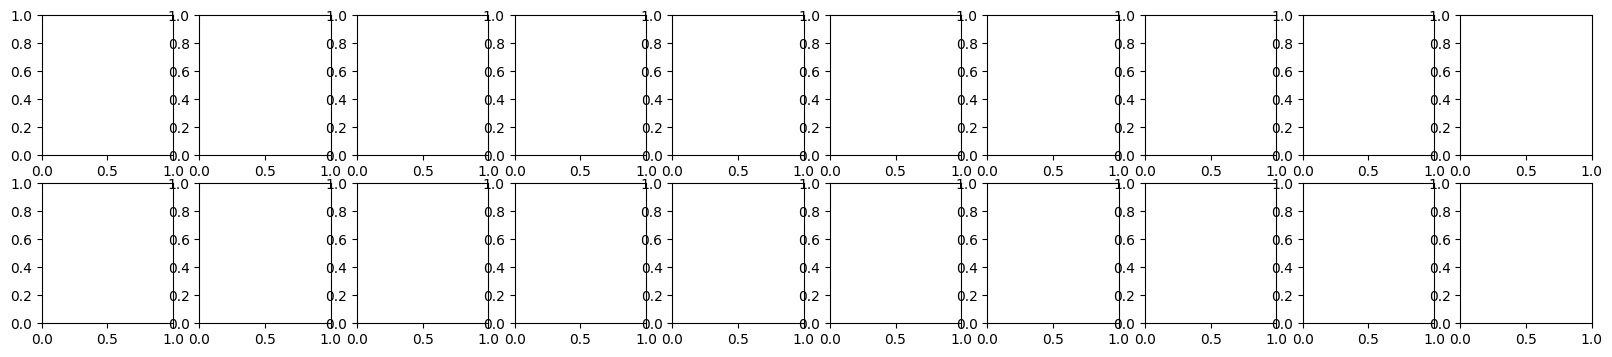

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# --- Hyperparameters ---
LEARNING_RATE = 0.001
BATCH_SIZE = 128
EPOCHS = 50
LATENT_DIM = 2  # Dimension of the latent vector
NUM_DIGITS = 10  # Number of Fashion MNIST classes

# --- Load and Preprocess the Fashion MNIST Dataset ---
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape images for convolutional layers
IMG_SHAPE = x_train.shape[1:] + (1,)
x_train = np.reshape(x_train, (-1,) + IMG_SHAPE)
x_test = np.reshape(x_test, (-1,) + IMG_SHAPE)

# Create TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BATCH_SIZE * 10).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

# --- Build the Encoder ---
class Encoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, kernel_size=3, activation='relu', strides=2, padding='same', input_shape=IMG_SHAPE)
        self.conv2 = layers.Conv2D(64, kernel_size=3, activation='relu', strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

# --- Build the Decoder ---
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(7 * 7 * 64, activation='relu')
        self.reshape = layers.Reshape((7, 7, 64))
        self.conv_transpose1 = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv_transpose2 = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')
        self.conv_transpose3 = layers.Conv2DTranspose(1, kernel_size=3, padding='same', activation='sigmoid')

    def call(self, z):
        x = self.dense1(z)
        x = self.reshape(x)
        x = self.conv_transpose1(x)
        x = self.conv_transpose2(x)
        x = self.conv_transpose3(x)
        return x

# --- Define the VAE Model ---
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder()

    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.encoder.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, log_var = self.encoder(x)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        eps = tf.random.normal(shape=tf.shape(mean))
        return eps * tf.exp(log_var * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

# --- Define the Loss Function ---
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    mean, log_var = model.encode(x)
    z = model.reparameterize(mean, log_var)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, log_var)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# --- Train the VAE ---
vae = VAE(LATENT_DIM)

for epoch in range(1, EPOCHS + 1):
    for train_x in train_dataset:
        train_step(vae, train_x)
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(vae, test_x))
    elbo = -loss.result()
    print(f'Epoch: {epoch}, Test set ELBO: {elbo:.4f}')



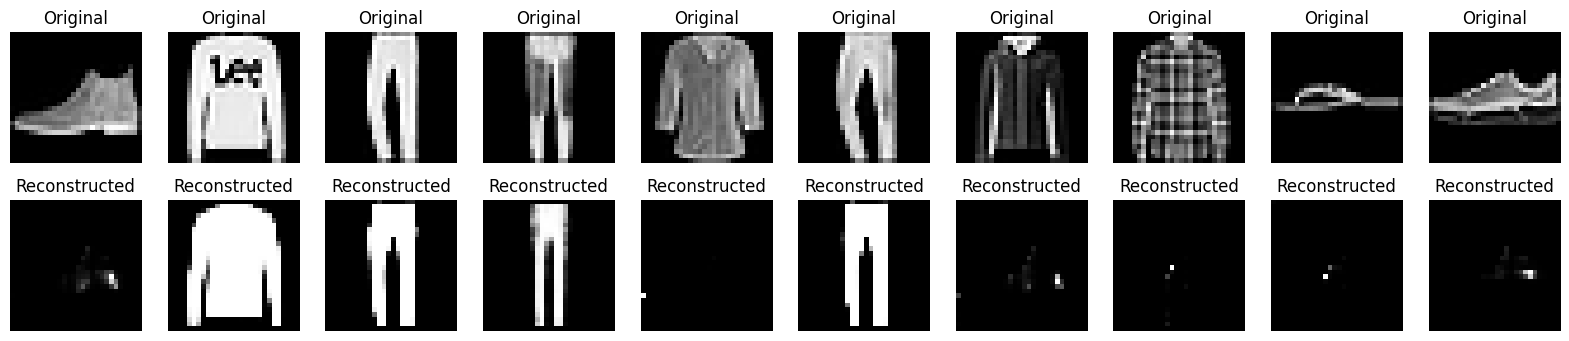

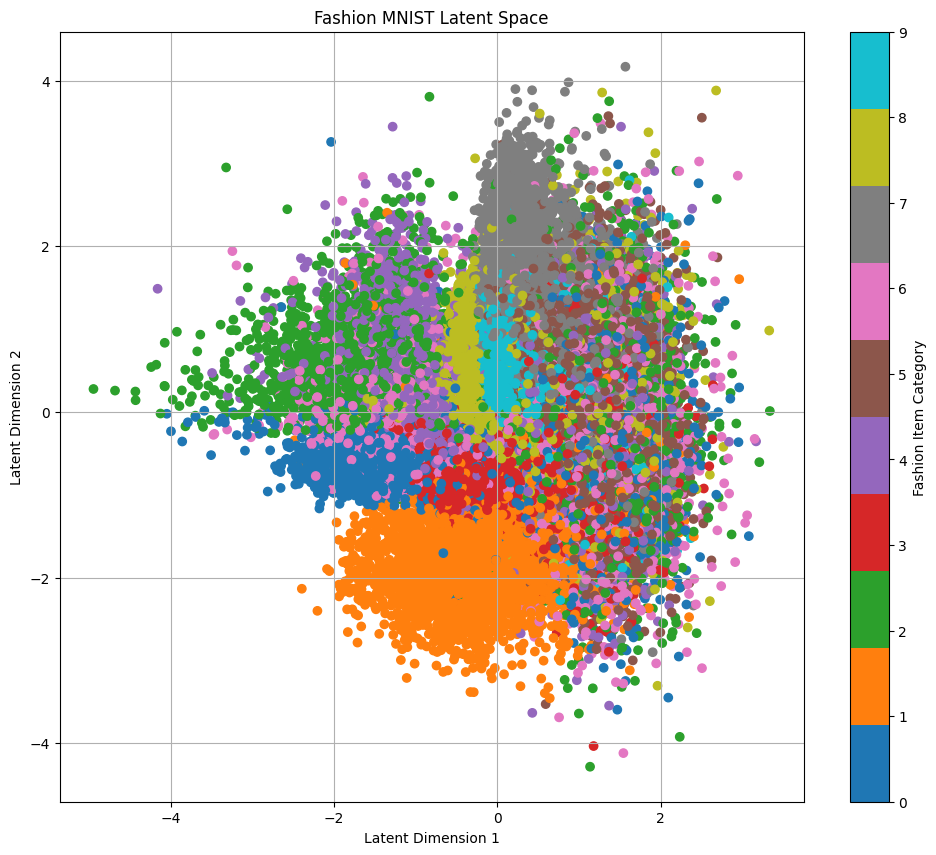

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



--- Accuracy on Latent Space ---
Accuracy of a Logistic Regression classifier trained on the VAE latent space: 0.4576


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy of a Logistic Regression classifier trained directly on pixel data: 0.8427


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# --- Visualize Reconstructions ---
def plot_reconstructions(model, n=10):
    examples = next(iter(test_dataset.take(1)))
    mean, log_var = model.encode(examples)
    z = model.reparameterize(mean, log_var)
    reconstructions = model.decode(z).numpy()
    fig, axes = plt.subplots(2, n, figsize=(n * 2, 4))
    for i in range(n):
        axes[0, i].imshow(tf.squeeze(examples[i]), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructions[i].squeeze(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

plot_reconstructions(vae)

# --- Visualize Latent Space (if latent_dim == 2) ---
if LATENT_DIM == 2:
    def plot_latent_space(model, data, labels, n=30):
        digit_size = 28
        scale = 1.0
        figsize = 15
        figure = np.zeros((digit_size * n, digit_size * n))
        grid_x = np.linspace(-scale, scale, n)
        grid_y = np.linspace(-scale, scale, n)[::-1]

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = np.array([[xi, yi]])
                x_decoded = model.decode(z_sample).numpy()
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

        plt.figure(figsize=(figsize, figsize))
        plt.imshow(figure, cmap='Greys_r')
        plt.xticks([])
        plt.yticks([])
        plt.title("Latent space of Fashion MNIST")
        plt.show()

    (x_train_vis, y_train_vis), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    x_train_vis = x_train_vis.astype('float32') / 255.0
    x_train_vis = np.reshape(x_train_vis, (-1,) + IMG_SHAPE)
    mean, log_var = vae.encode(x_train_vis)
    z = vae.reparameterize(mean, log_var).numpy()
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z[:, 0], z[:, 1], c=y_train_vis, cmap='tab10')
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.colorbar(scatter, label='Fashion Item Category')
    plt.title("Fashion MNIST Latent Space")
    plt.grid()
    plt.show()

# --- Accuracy Section (for Classification using the Latent Space) ---
# Note: VAEs are primarily generative models, not discriminative classifiers.
# However, we can train a separate classifier on the learned latent space
# to evaluate how well the latent representation captures the class information.

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Encode the training and testing data into the latent space
mean_train, _ = vae.encode(x_train)
z_train = mean_train.numpy()  # Using the mean as the latent representation for simplicity
mean_test, _ = vae.encode(x_test)
z_test = mean_test.numpy()

# Train a Logistic Regression classifier on the latent space
classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)
classifier.fit(z_train, y_train)

# Predict on the latent space of the test data
y_pred_latent = classifier.predict(z_test)

# Calculate the accuracy
latent_accuracy = accuracy_score(y_test, y_pred_latent)
print(f"\n--- Accuracy on Latent Space ---")
print(f"Accuracy of a Logistic Regression classifier trained on the VAE latent space: {latent_accuracy:.4f}")

# --- Optional: Train a Logistic Regression directly on the pixel data for comparison ---
classifier_pixels = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=500)
classifier_pixels.fit(x_train.reshape(x_train.shape[0], -1), y_train)
y_pred_pixels = classifier_pixels.predict(x_test.reshape(x_test.shape[0], -1))
pixel_accuracy = accuracy_score(y_test, y_pred_pixels)
print(f"Accuracy of a Logistic Regression classifier trained directly on pixel data: {pixel_accuracy:.4f}")